# Signal processing using Scipy

In this notebook we will explore how the [scipy](https://scipy.org/scipylib/) package can be used to perform signal processing.

Scipy stands for *sci*entific *py*thon, and is a package with a vast range of modules for a range of scientific computing problems. From linear algebra to optimization; from integration to interpolation: it is the go-to Python package for traditional scientific computing problems. Scipy is built from numpy's `ndarray`, and scipy interfaces with `matlotlib` for visuals. So when working with scipy it is essential we also have numpy and matplotlib imported too.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Scipy is a large package with many submodules. It is standard to just import the modules we will be working with on a givgen task. In this notebook, we'll be using the module `signal`, which give access to methods related to signal processing. We will also need some helper functions for reading in signals, from the `scipy.io` module.

In [2]:
from scipy import signal
from scipy.io import wavfile

## Working with signals
A signal is a series of measurements over time, related to some phenmomenon. It could be the light emitted from a chemical reaction, sound transmitted through the air, or the heat of an organism throughout some biological process. When we work with signals in python, we are considering digital signals: samples of a signal taken at discrete time-steps. Today we will be working with a familiar signal: we'll be working with audio signals (i.e. those coming from sound waves). 

### Reading in a wav audio file
Let's see how we can represent an audio signal in python. We are going to use the `wavfile.read` helper to read in a recording of a guitar chord (you can listen to it by clicking on the file in the Jupyter folder).

In [3]:
chord = wavfile.read("data/chord-11.wav")

/opt/conda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


This function returns a tuple. The first element is the sample rate, and the second is the actual data from the file.

In [4]:
chord

(44100, array([[ -8,  45],
        [ 30,  91],
        [ 82, 129],
        ...,
        [  0,   0],
        [  0,   0],
        [  0,   0]], dtype=int16))

Plotting the data from the wav with `plt` will give the charactersitic plot of the sound wave that we're used to.

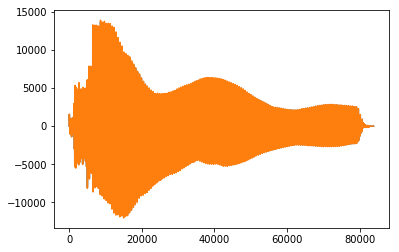

In [5]:
plt.plot(chord[1])
plt.show()

To check we're doing things correctly, let's write that data back to another file. By opening the original file and the file we've written, you should convince yourself that the numpy array created by `wavfile.read` really does represent the audio signal of the wav file.

In [6]:
wavfile.write("data/test.wav", chord[0], chord[1])

### Converting to Mono
Many sound signals are multi-channel, and often we store audio in stereo. In fact, the audio signal `chord` is in stereo. The audio data is a list of pairs. Each pair represents a point in time: the first value is the data from the L channel, and the secon is the data from the R channel.

In [7]:
chord[1]

array([[ -8,  45],
       [ 30,  91],
       [ 82, 129],
       ...,
       [  0,   0],
       [  0,   0],
       [  0,   0]], dtype=int16)

For simplicity, we will work only with mono signals for the remainder of this notebook. Your first task is to write a function `to_mono`, which takes a tuple representing a sound signal, and returns another sound signal by averaging the data fro each time-step. The data part of your sound signal should be an array of `np.int16` data.

In [8]:
def to_mono(sound):
    if sound[1].shape ==1:
        return sound
    else:
        aves = []
        for t in sound[1]:
            aves.append(np.mean(t))
        return sound[0], np.array(aves, dtype=np.int16)

Now, replace `chord` with its mono version. Plot this signal, and write it to a wav file. Does it sound similar to the file you started with?

In [9]:
chord = to_mono(chord)
chord[1]

array([ 18,  60, 105, ...,   0,   0,   0], dtype=int16)

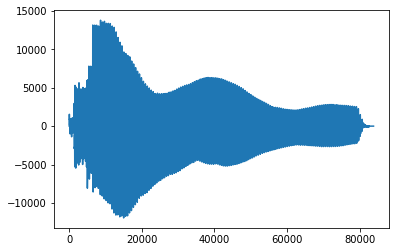

In [10]:
plt.plot(chord[1])
plt.show()

In [11]:
wavfile.write("data/test.wav", chord[0], chord[1])

### Power Spectral Density
The Power Spectral Density (psd) is a way of estimating how a signal breaks into its component parts. With audio signals, it tells us how we could have built up our original signal by combining certain elementary (sin and cosine) sound waves. It's a bit like trying to "unmix" coloured paint to figure out how much red, blue and yellow went into a given colour. The process is quite complicated, so for the purposes of this notebook we will just understand it at this high level: given a signal, the PSD gives us an estimate of its decomposition into elementary waves, which is like a kind of fingerprint unique to that signal. The PSD is related to the Fourier transform, which you may have heard of - in fact, we can use the Fourier transform to estimate PSD.

In `scipy.signal`, the `periodogram` method computes the PSD of a signal. We need to supply the signal data, as well as the sample rate. Then `signal.periodogram` returns an array of frequencies, and a corresponding array representing the Power Spectral Density: how much of each pure frequency went into the original signal.

In [12]:
psd = signal.periodogram(chord[1], fs = chord[0])
psd

(array([0.00000000e+00, 5.26315789e-01, 1.05263158e+00, ...,
        2.20489474e+04, 2.20494737e+04, 2.20500000e+04]),
 array([2.9092380e-26, 6.8505745e+00, 6.6323647e+00, ..., 2.3682150e-03,
        2.6045353e-05, 4.7440056e-04], dtype=float32))

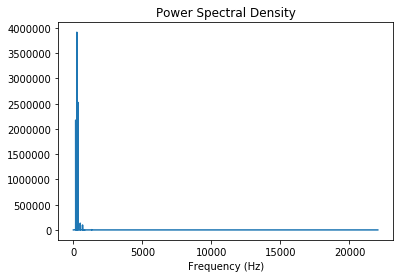

In [13]:
plt.plot(psd[0], psd[1])
plt.xlabel("Frequency (Hz)")
plt.title("Power Spectral Density")
plt.show()

## Comparing Yes and No
Suppose we want to classify between recordings of the word "yes", and the word "no". Of course, spoeech recognition is a huge problem and we would need much more than just the PSD to tackle it in general. But if we know in advance that a signal will be saying "yes" or "no" (for example suppose we were creating an automatic phone system for a big company, that asks the caller a question and routes them according to their answer). Then it turns out that the PSD is in fact enough to differentiate betwenn them.

Let's see this in action.

In [14]:
# Obtain mono versions of the recordings
yes = to_mono(wavfile.read("data/yes_male.wav"))
no = to_mono(wavfile.read("data/no_male.wav"))

In [15]:
# Get psds
yes_psd = signal.periodogram(yes[1], fs=yes[0])
no_psd = signal.periodogram(no[1], fs=no[0])

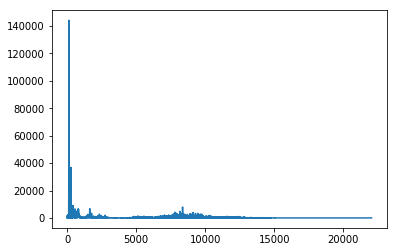

In [16]:
# PSD for yes
plt.plot(yes_psd[0], yes_psd[1])
plt.show()

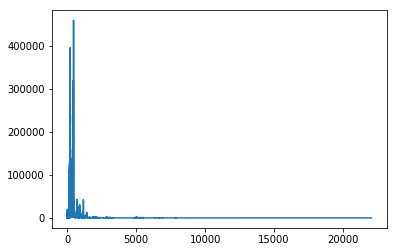

In [17]:
# PSD for no
plt.plot(no_psd[0], no_psd[1])
plt.show()

We can see that the signal for "no" does not contain as much high-frequency as the signal for "yes". We will try to create a classifier based on this feature.

## Developing a Feature
We will now develop a feature based on the observation above. One possibility is to add up the PSD for low frequencies, and divide it by the PSD for high frequencies. Looking at the plots above, we can try placing the line between low and high frequency at 5000 Hz. Then a recording of the word "no" should have a higher value than a recording of the word "yes". This feature is not sensitive to the length of the recording, and neither is it affected by different volume leves since it is a ratio.

Write a function `get_feature` which accepts the PSD of a signal, and returns the feature.

In [18]:
def get_feature(psd):
    lo = 0
    hi = 0
    for i in range(len(psd[0])):
        if psd[0][i] <= 5000:
            lo += psd[1][i]
        else:
            hi += psd[1][i]
    return hi/lo

Now we need to try our function on some known recordings, to find a threshold value for the feature which distinguishes "yes" from "no". In `data/yes` and `data/no` are different recordings of the words yes and no: these recordings are our training data. The paths of these files are tored in the csv `data/scipy_training_files.csv`.

Use numpy to obtain two lists, `yes_paths` and `no_paths`, from the file `scipy_training_files.csv`. The lists should contain the file paths of the training data.

In [19]:
paths = np.genfromtxt("data/scipy_training_files.csv", dtype=np.str, delimiter=",")
yes_paths = paths[0]
no_paths = paths[1]

Now we need to choose a threshold value, below which the feature indicates a "yes" and above which it indicates a "no". We will decide a threshold value by eye in this exercise.

You should write code to:
- Read in all of the files with filepaths given in `yes_paths`
- Compute the feature value for each recording
- Repeat the above for the `no_paths` folder

In [20]:
y_feats = []
for s in yes_paths:
    sound = to_mono(wavfile.read(s))
    psd = signal.periodogram(sound[1], fs=sound[0])
    feat = get_feature(psd)
    y_feats.append(feat)

/opt/conda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [21]:
n_feats = []
for s in no_paths:
    sound = to_mono(wavfile.read(s))
    psd = signal.periodogram(sound[1], fs=sound[0])
    feat = get_feature(psd)
    n_feats.append(feat)

/opt/conda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Now use `plt` to produce an overlaid plot of two histograms - one counting the feature values for "yes" recordings, the other counting the feature values for "no" recordings. To make things easier to interpret, you should use the same bins for each histogram - at first, set the bins to be of size 0.01 on the range from 0 to 3. Passing a list of the endpoints of the bins to `plt.hist` will control the size of the bins used.

Your plot should have a legend, and will be easier to read if you set the parameter `alpha=0.5` in each call to `plt.hist` (this makes the plots appear slightly transparent).

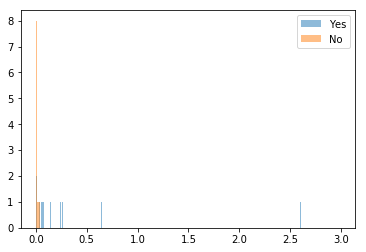

In [22]:
bins = np.arange(0, 3, 0.01)
plt.hist(y_feats, bins, alpha=0.5, label="Yes")
plt.hist(n_feats, bins, alpha = 0.5, label="No")
plt.legend()
plt.show()

As we can see, there are some "Yes" outliers at the upper end of the scale, making it difficult to see what's happening at the low end. We can copy the above code and change the range of our binning to restrict the plot to the low end of the scale.

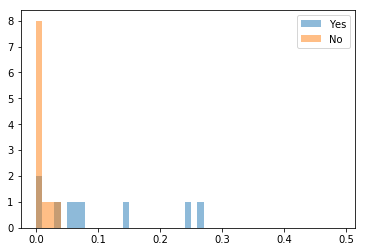

In [23]:
bins = np.arange(0, 0.5, 0.01)
plt.hist(y_feats, bins, alpha=0.5, label="Yes")
plt.hist(n_feats, bins, alpha = 0.5, label="No")
plt.legend()
plt.show()

Having inspected the above data, determine what you believe to be a good threshold value for this calculation. To choose an exact value, you may wish to inspect the values given in `y_feats` and `n_feats`.

## Testing Your Classification
Write a function `classify_yesno` which takes in a sound (a bitrate/data tuple), and classifies whether this is the word "yes" or the word "no". You should return the string `"Y"` for yes, and `"N"` for no.

In [24]:
def classify_yesno(sound):
    thresh = 0.023
    psd = signal.periodogram(sound[1], fs=sound[0])
    feat = get_feature(psd)
    if feat > thresh:
        return "Y"
    else:
        return "N"

Now run the function below. It will test your classifier against test data, and plot the confusion matrix.

In [25]:
TP = 0
FP = 0
TN = 0
FN = 0

paths = np.genfromtxt("data/scipy_test_files.csv", dtype=np.str, delimiter=",")
yes_tests = paths[0]
no_tests = paths[1]

for s in yes_tests:
    sound = to_mono(wavfile.read(s))
    if classify_yesno(sound) == "Y":
        TP += 1
    else:
        FN += 1
        
for s in no_tests:
    sound = to_mono(wavfile.read(s))
    if classify_yesno(sound) == "N":
        TN += 1
    else:
        FP += 1
        
confusion_matrix = np.reshape(np.array([TP, FP, FN, TN]), (2, 2))

confusion_matrix

array([[5, 0],
       [3, 8]])

The (0, 0) entry of this matrix shows how many "yes" recordings were correctly classified as such, and the (1, 1) entry shows how many "no" recordings were properly classified. The other entries show the mistakes. Since we tested our classifier on 8 samples of each type, then the closer our matrix looks to $$\begin{bmatrix}8 & 0\\ 0 & 8 \end{bmatrix}$$ the better our classifier is performing. We could also compute a summary statistic such as the [F1-score](https://en.wikipedia.org/wiki/F1_score) of the classifier, or a host of other analyses to get an idea of its performance.

In reality, we'd likely train and test on much more data. We would also train the classifier using some form of predictive model, rather than by eyeballing the data. Packages such as [scikit-learn](https://scikit-learn.org/stable/index.html) have easy-to-use inbuilt functions for building and testing classifiers (in fact, sklearn has its own project notebook as part of this course).

## References
This notebook was based on a project from "Enhance your DSP Course with these Interesting Projects" by D. Hoffbeck, in proceedings AC 2012-3836, the American Society for Engineering Education, 2012. 

Training files were obtained from freesound. Licensing info and accreditation is given in scipy_training_licensing.txt.

Testing files were recorded by the author.